In [4]:
import qiskit
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from qiskit.providers.aer import AerSimulator

In [5]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.22.0', 'qiskit-aer': '0.11.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [6]:
#input length of qubits
n = 3

In [7]:
#create constant oracle 
#oracle always returns only 0's or only 1's
const_oracle = QuantumCircuit(n+1)
output = np.random.randint(2)
#if output is 1 apply the x-gate to the 0 state
if output == 1:
    const_oracle.x(n)

#draw the constant oracle
const_oracle.draw()

q_0: 
     
q_1: 
     
q_2: 
     
q_3:

In [8]:
#create a balanced oracle 
#input 3 qubits 
#output 1 qubit
n=3
balanced_oracle = QuantumCircuit(n+1)
#define binary string of length n
b_str = '101'
    

#place x-gates if the corresponding digit in b_str is 1 
#do nothing if the digit is 0
for i in range(len(b_str)):
    if b_str[i] == '1':
        balanced_oracle.x(i)

balanced_oracle.barrier()

#apply contolled-NOT gates using input qubit as control 
#and output qubit as target
for i in range(n):
    balanced_oracle.cx(i,n)

balanced_oracle.barrier()

#place x-gates
for i in range(len(b_str)):
    if b_str[i] == '1':
        balanced_oracle.x(i)

In [9]:
#full circuit
circuit = QuantumCircuit(n+1,n)

#Hadamard gates at the beginning
for i in range(n):
    circuit.h(i)

#put in |-> state for q3
circuit.x(3)
circuit.h(3)

# apply oracle
circuit += balanced_oracle

#apply Hadamard gates at the end 
for i in range(n):
    circuit.h(i)

circuit.barrier()

#measure qubits
for i in range(n):
    circuit.measure(i,i)

circuit.draw()

/var/folders/05/9y6gplnj7kg_9m62mlq2tlqr0000gn/T/ipykernel_21712/1521144385.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circuit += balanced_oracle


┌───┐┌───┐ ░                 ░ ┌───┐┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├┤ H ├─░─┤M├──────
     ├───┤└───┘ ░   │             ░ ├───┤└───┘ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├──────░──╫─┤M├───
     ├───┤┌───┐ ░   │    │        ░ ├───┤┌───┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘└───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░────────────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░            ░  ║  ║  ║ 
c_0: ═════════════════════════════════════════════╩══╬══╬═
                                                     ║  ║ 
c_1: ════════════════════════════════════════════════╩══╬═
                                                        ║ 
c_2: ═══════════════════════════════════════════════════╩═

In [76]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # if oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
    
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
                
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
            
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [77]:
def dj_algorithm(oracle, n):
    # Also add n classical bits to write the output to
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [78]:
#build the circuit of the Deutsch-Jozsa algorithm for n qubits

n=3
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()




┌───┐     ┌─────────┐┌───┐┌─┐      
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├──────
     ├───┤     │         │├───┤└╥┘┌─┐   
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├───
     ├───┤     │  Oracle │├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2        ├┤ H ├─╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3        ├──────╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║ 
c_0: ═══════════════════════════╩══╬══╬═
                                   ║  ║ 
c_1: ══════════════════════════════╩══╬═
                                      ║ 
c_2: ═════════════════════════════════╩═

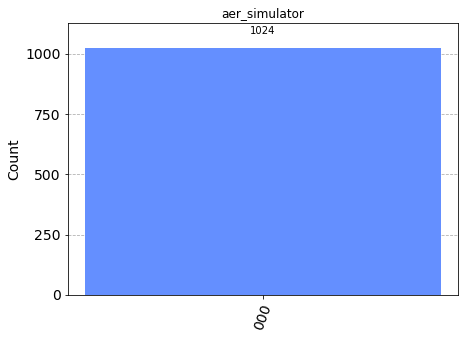

In [79]:
#simulate the case of 4 input qubits on the noisless simulator
#then simulate on 2 different quantum computers with noise 

#noisless simulations

simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(dj_circuit, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)

plot_histogram(counts, title="aer_simulator")

/var/folders/05/9y6gplnj7kg_9m62mlq2tlqr0000gn/T/ipykernel_21712/3028869416.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo,FakeCasablanca


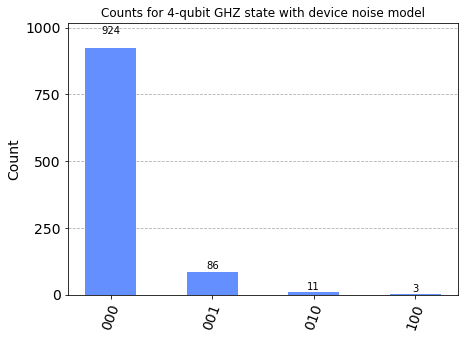

In [80]:
#use of noisy simulator
from qiskit.test.mock import FakeVigo,FakeCasablanca
device_backend = FakeVigo()

# Transpile the circuit for the noisy basis gates
sim_vigo = AerSimulator.from_backend(device_backend)
tcirc = transpile(dj_circuit, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 4-qubit GHZ state with device noise model")




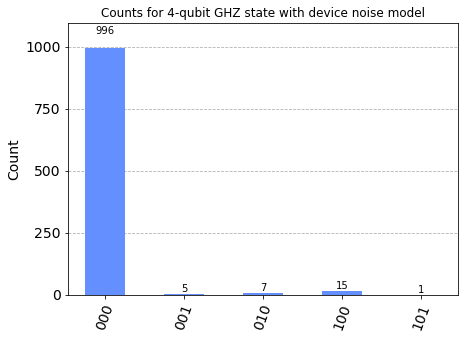

In [81]:
device_backend = FakeCasablanca()

# Transpile the circuit for the noisy basis gates
sim_casa = AerSimulator.from_backend(device_backend)
tcirc = transpile(dj_circuit, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_casa.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 4-qubit GHZ state with device noise model")


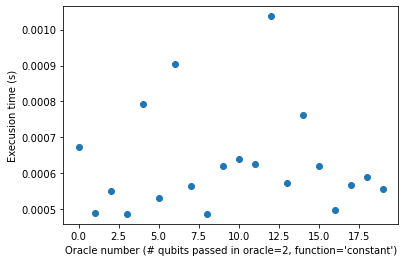

In [82]:
import time
import matplotlib.pyplot as plt
time_for_diff_oracles=[]
for i in range(20):
    start_time = time.time()
    n=2
    oracle_gate = dj_oracle('constant', n)
    dj_circuit = dj_algorithm(oracle_gate, n)
    time_for_diff_oracles.append(time.time()-start_time)
    
plt.plot(range(20),time_for_diff_oracles,"o")
plt.xlabel("Oracle number (# qubits passed in oracle=2, function='constant')")
plt.ylabel("Execusion time (s)")
plt.savefig("oracle_execusion_dj.pdf")
plt.show()
    


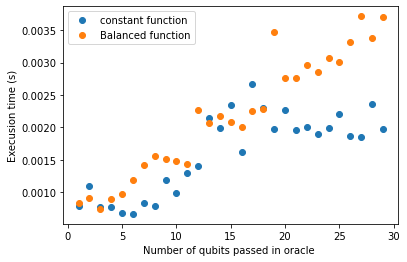

In [84]:
time_for_diff_n=[]
for i in np.arange(1,30,1):
    start_time = time.time()
    n=i
    b = np.random.randint(1,2**n)
    b_str = format(b, '0'+str(n)+'b')
    oracle_gate = dj_oracle('constant', n)
    dj_circuit = dj_algorithm(oracle_gate, n)
    time_for_diff_n.append(time.time()-start_time)
    
plt.plot(np.arange(1,30,1),time_for_diff_n,"o",label="constant function")
plt.xlabel("Number of qubits passed in oracle ")
plt.ylabel("Execusion time (s)") 



time_for_diff_n=[]
for i in np.arange(1,30,1):
    start_time = time.time()
    n=i
    b = np.random.randint(1,2**n)
    b_str = format(b, '0'+str(n)+'b')
    oracle_gate = dj_oracle('balanced', n)
    dj_circuit = dj_algorithm(oracle_gate, n)
    time_for_diff_n.append(time.time()-start_time)
    
plt.plot(np.arange(1,30,1),time_for_diff_n,"o",label="Balanced function")
plt.xlabel("Number of qubits passed in oracle ")
plt.ylabel("Execusion time (s)") 
plt.legend()
plt.savefig("n_qubit_execusion_dj.pdf")
plt.show()